In [1]:
#@title Connect to google drive

from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title Clone project github
! git clone https://github.com/noellelaw/dlf22-miniproject
%cd /content/dlf22-miniproject

Cloning into 'dlf22-miniproject'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 103 (delta 59), reused 71 (delta 36), pack-reused 0
Receiving objects: 100% (103/103), 29.22 KiB | 7.30 MiB/s, done.
Resolving deltas: 100% (59/59), done.
/content/dlf22-miniproject


In [4]:
#@title Import needed libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import numpy as np

import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

import os
import argparse

from models import resnet, resnet_F5x5, resnet_L3, resnet_L2, resnet_L3K3, resnet_L3_LReLU
from augmentation.cutout import Cutout

In [5]:
#@title Define hyperparameters
BATCH_SIZE = 64 #@param {type:'integer'}
LEARNING_RATE = 5e-3 #@param {type:'number'}
WEIGHT_DECAY = 5e-4 #@param {type:'number'}
MOMENTUM = 0.9 #@param {type:'number'}
# Threshold for amount of times model doesn't
# improve before training is stopped
PATIENCE = 10 #@param {type:'integer'}
# Minimum change in validation accuracy that
# qualifies as improvement
MIN_DELTA = 7 #@param {type:'integer'}
NUM_EPOCHS = 100 #@param {type:'integer'}
CKPT_FILE = 'ckpt_RN38_LReLU_cutout16.pth' #@param {type:'string'} 
CKPT_FLDR = '/content/drive/MyDrive/checkpoint/' #@param {type: 'string'}
RESUME = False #@param {type:'boolean'}
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CKPT_PATH = os.path.join(CKPT_FLDR + CKPT_FILE )
CUTOUT_SIZE = 16 #@param {type:'integer'

In [6]:
#@title Define CIFAR-10 classes
CLASSES = ('plane', 
           'car', 
           'bird', 
           'cat', 
           'deer',
           'dog', 
           'frog', 
           'horse', 
           'ship', 
           'truck')

In [7]:
#@title Transform train set images
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    Cutout(1, CUTOUT_SIZE)
])

In [8]:
#@title Transform validation set images
transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [9]:
#@title Get train and test sets from CIFAR-10
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_valid)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [10]:
#@title Define train and validation data loaders
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

validloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [11]:
#@title Build model, be sure to select model here
net = resnet_L3_LReLU.ResNet38()
net = net.to(DEVICE)

if RESUME:
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(CKPT_PATH)
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), 
                      lr=LEARNING_RATE,
                      momentum=MOMENTUM, 
                      weight_decay=WEIGHT_DECAY)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [12]:
#@title Print out ResNet model summary 
summary(net, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [13]:
#@title Define an early stopper class
# Code adapted from: https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
class EarlyStopper():
    def __init__(self, patience=3, min_delta=5):
        self.patience = patience
        self.min_delta = min_delta
        self.prev_validation_acc = 0 
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_acc, validation_acc):
      inter_delta = (train_acc - validation_acc) 
      if (inter_delta > self.min_delta) and (validation_acc < self.prev_validation_acc):
          self.counter +=1
          if self.counter >= self.patience:  
              self.early_stop = True
      
      self.prev_validation_acc = validation_acc



In [14]:
#@title Train loop
def train(epoch):
    print('\n|Epoch: %d ------------------------------|' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = 100.*train_loss/total
    acc = 100.*correct/total
    print(f'Train loss:     {np.round(train_loss,2)}e-2')
    print(f'Train accuracy: {acc}%')
    return acc, train_loss


In [15]:
#@title Test loop
def test(epoch):
    global best_acc
    net.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(validloader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    # Save checkpoint.
    acc = 100.*correct/total
    val_loss = 100.*val_loss/total
    print(f'Validation loss:     {np.round(val_loss,2)}e-2')
    print(f'Validation accuracy: {acc}%')
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }

        if not os.path.isdir( CKPT_FLDR ):
          os.mkdir( CKPT_FLDR )
        torch.save(state, CKPT_PATH)
        best_acc = acc
    return acc, val_loss

In [16]:
#@title Run training for defined number of epochs

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
accuracy = {
    'train': [],
    'validation': []
    }
loss= {
    'train': [],
     'validation': []
     }
early_stopper = EarlyStopper(patience=PATIENCE,
                             min_delta=MIN_DELTA)
EPOCHS_COMPLETED = 0
for epoch in range(NUM_EPOCHS):
    train_acc, train_loss = train(epoch)
    val_acc, val_loss = test(epoch)
    #--------------------------------------
    accuracy['train'].append(train_acc)
    accuracy['validation'].append(val_acc)
    loss['train'].append(train_loss)
    loss['validation'].append(val_loss)
    #--------------------------------------
    early_stopper(train_acc, val_acc)
    EPOCHS_COMPLETED += 1
    if early_stopper.early_stop:      
        print('Model appears to be overfitting, stopping early.')       
        break
    #--------------------------------------
    #scheduler.step() Want to better control lr


|Epoch: 0 ------------------------------|
Train loss:     2.49e-2
Train accuracy: 40.678%
Validation loss:     2.24e-2
Validation accuracy: 49.95%
Saving..

|Epoch: 1 ------------------------------|
Train loss:     1.79e-2
Train accuracy: 58.868%
Validation loss:     2.1e-2
Validation accuracy: 60.53%
Saving..

|Epoch: 2 ------------------------------|
Train loss:     1.44e-2
Train accuracy: 67.296%
Validation loss:     1.32e-2
Validation accuracy: 72.18%
Saving..

|Epoch: 3 ------------------------------|
Train loss:     1.26e-2
Train accuracy: 71.714%
Validation loss:     1.14e-2
Validation accuracy: 75.71%
Saving..

|Epoch: 4 ------------------------------|
Train loss:     1.13e-2
Train accuracy: 74.786%
Validation loss:     1.03e-2
Validation accuracy: 79.18%
Saving..

|Epoch: 5 ------------------------------|
Train loss:     1.03e-2
Train accuracy: 77.088%
Validation loss:     0.89e-2
Validation accuracy: 81.51%
Saving..

|Epoch: 6 ------------------------------|
Train loss:     

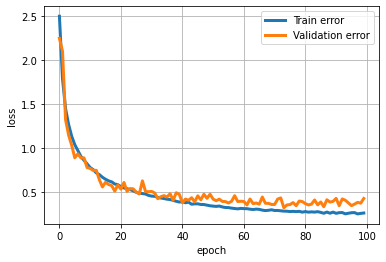

In [17]:
#@title Plot test and train loss 
import matplotlib.pyplot as plt

plt.plot(range(EPOCHS_COMPLETED),
         loss['train'],
         '-',
         linewidth=3,
         label='Train error')
plt.plot(range(EPOCHS_COMPLETED),loss['validation'],'-',linewidth=3,label='Validation error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()


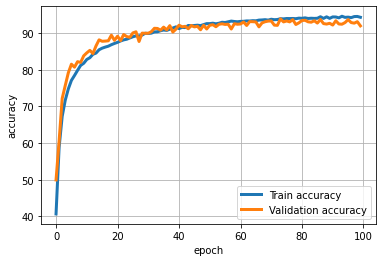

In [18]:
#@title Plot test and train accuracy 
import matplotlib.pyplot as plt

plt.plot(range(EPOCHS_COMPLETED),
         accuracy['train'],
         '-',
         linewidth=3,
         label='Train accuracy')
plt.plot(range(EPOCHS_COMPLETED),
        accuracy['validation'],
        '-',
        linewidth=3,
        label='Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()